# MUSIC for DOA estimation


### 1 Introduction
In this paragraph, some simulations about factors affecting the DOA estimation are introduced. 

### 2 Setup


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from helper import *
import import_ipynb
from assignment_1_generated_data import basic_musicDOA

In [2]:
angles = np.array([20., 60., -30., -35.])
freqs = np.array([1/2, 1/3, 1/5, 1/10])
thetas = np.array(angles) / 180 * np.pi       
w = np.array(freqs)*2*np.pi     
N = 200                         
M = 10                          
D = np.size(thetas)                     
wavelen = 150                           
d = wavelen / 2                         
var = 0.10      


### 3.1 Relationship between number of snapshots and DOA estimation
* Number of snapshots = 5, 10, 50, 200

Simulations have proved that, as the number of snapshots grows, the beam width of the DOA estimation spectrum becomes narrower and the accuracy of MUSIC algorithm increases.
Therefore, it is possible to improve the accuracy of the DOA estimation with a greater number of sampled snapshots, but the more sampled snapshots are considered, the more data needs to be processed and the speed results lower.

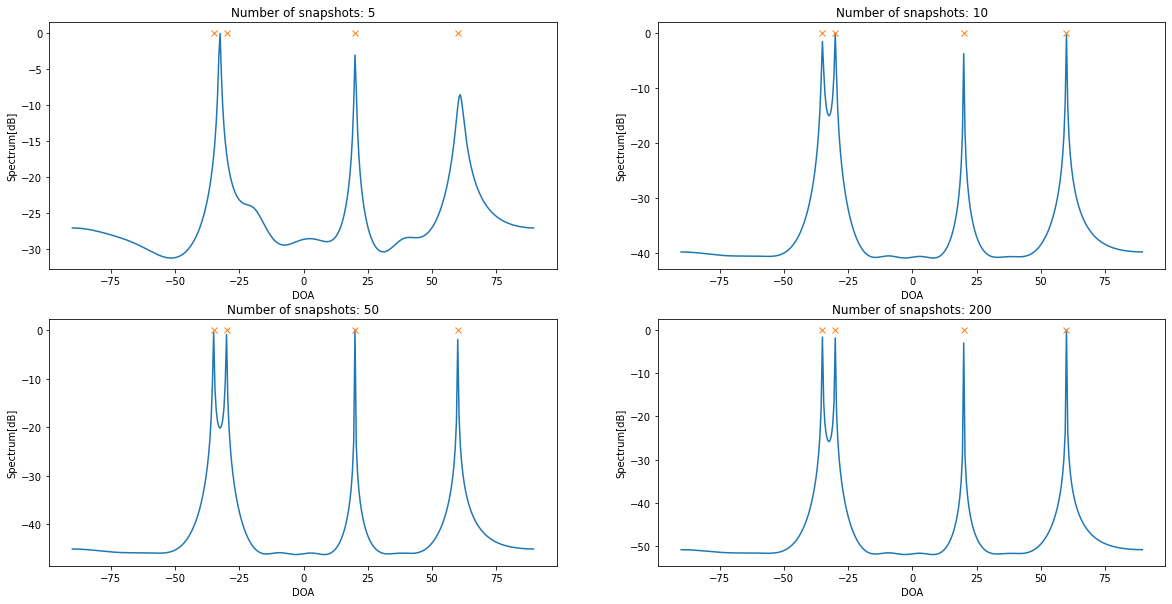

In [3]:
plt.figure(figsize=((20,10)))
snapshots = [5, 10, 50, 200]
for i, n in enumerate(snapshots):
    X = generate_data(M,n,d,wavelen,angles,freqs,var)
    Pmusic, peak_search_range= basic_musicDOA(X,M,d,wavelen,thetas)
    plt.subplot(221+i)
    plt.plot(peak_search_range, Pmusic)
    plt.title("Number of snapshots: %d"%n)
    plt.plot(angles,np.zeros(angles.size),"x")
    plt.xlabel("DOA")
    plt.ylabel("Spectrum[dB]")
plt.show()

### 3.2 Relationship between number of microphones and DOA estimation
* Number of microphones M = 5, 10, 50, 100

Simulations have proved that, as the number of array elements increases, the estimated spectral beam width becomes narrower and the ability to distinguish spatial signals enhances.
Therefore, a more accurate estimation of DOA can be obtained by increasing the number of array elements, but the larger the number of arrays is, the more calculations will be done and consequently the speed will decrease.



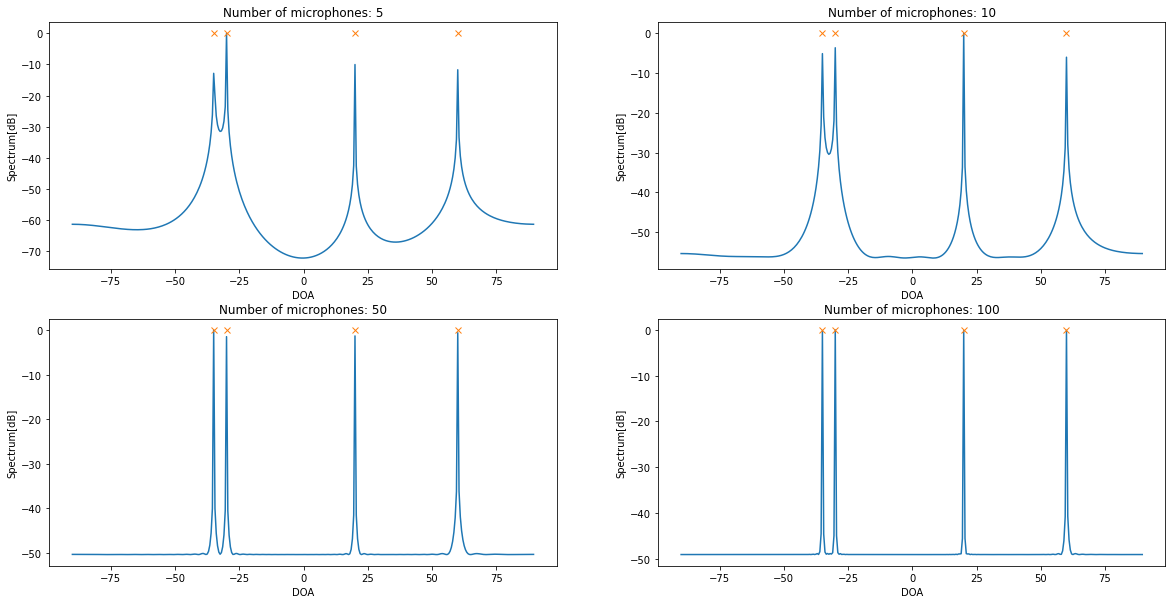

In [4]:
plt.figure(figsize=(20,10))
NAs=[5,10,50,100]
for i, m in enumerate(NAs):
    X = generate_data(m,N,d,wavelen,angles,freqs,var)
    Pmusic, peak_search_range= basic_musicDOA(X,m,d,wavelen,thetas)
    plt.subplot(221+i)
    plt.plot(peak_search_range, Pmusic)
    plt.title("Number of microphones: %d"%m)
    plt.plot(angles,np.zeros(angles.size),"x")
    plt.xlabel("DOA")
    plt.ylabel("Spectrum[dB]")
plt.show()

### 3.3 Relationship between microphone distance and DOA estimation
 * Distance d = Wavelen/6, Wavelen/4, Wavelen/2, Wavelen
 
 
Simulations have proved that, when the array element spacing does not exceed the half of the wavelength, as the array element spacing increases, the beam width of the DOA estimation spectrum becomes narrower. If the spacing of array elements is larger than the half of the wavelength, the estimated spectrum shows false peaks affecting the estimation accuracy.

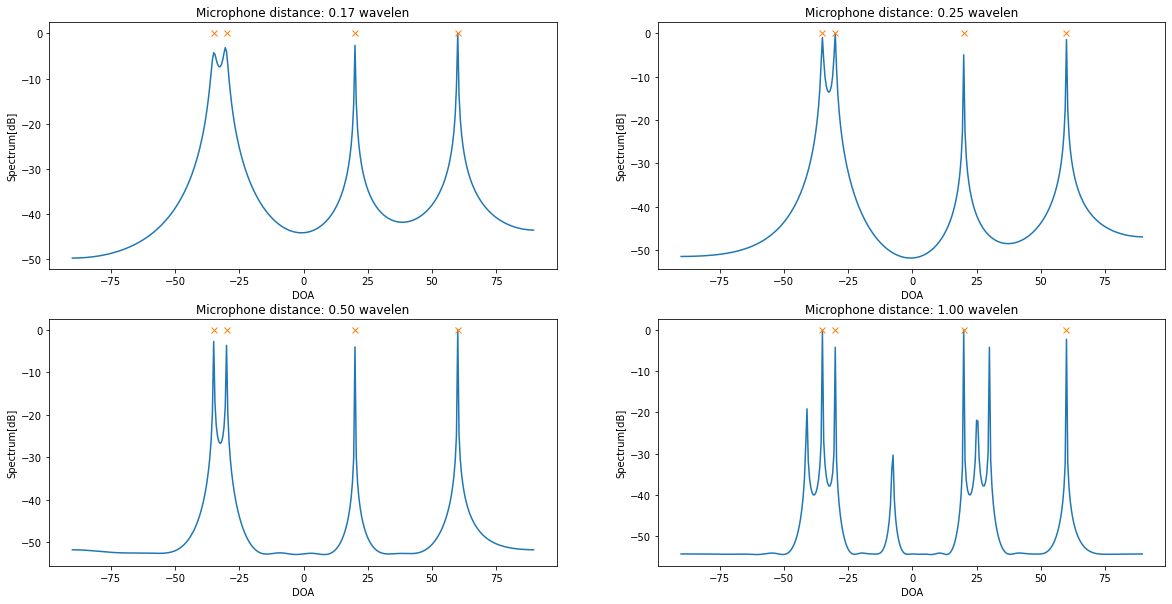

In [5]:
plt.figure(figsize=(20,10))
Ds=[wavelen/6,wavelen/4,wavelen/2,wavelen] 
for j,i in enumerate(Ds):
    X = generate_data(M,N,i,wavelen,angles,freqs,var)
    Pmusic, peak_search_range= basic_musicDOA(X,M,i,wavelen,thetas)
    plt.subplot(221+j)
    plt.plot(peak_search_range, Pmusic)
    plt.title("Microphone distance: %0.2f wavelen"%(i/wavelen))
    plt.plot(angles,np.zeros(angles.size),"x")
    plt.xlabel("DOA")
    plt.ylabel("Spectrum[dB]")
plt.show()

### 3.4  Relationship between noise and DOA estimation
* Var = 0.01, 0.1, 0.5, 1

The simulation proves that, as the noise variance decreases, the estimated spectral beam width becomes narrower and the directivity of the array increases. In this way, the ability to distinguish spatial signals enhances.

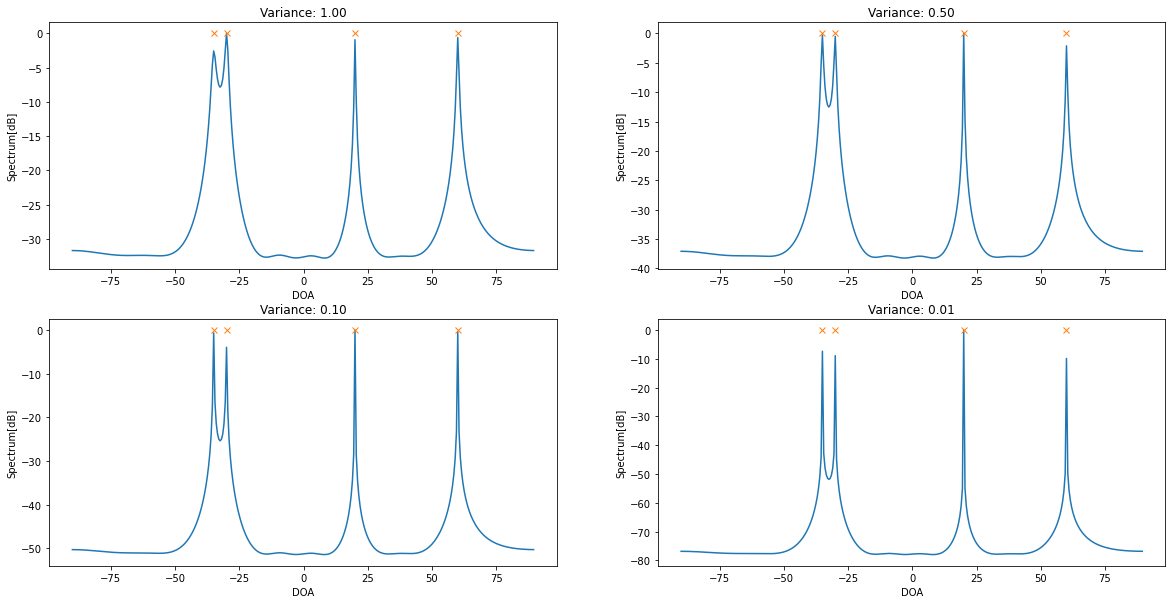

In [6]:
plt.figure(figsize=(20,10))
Vars=[1, 0.5, 0.1, 0.01]     
for i, v in enumerate(Vars):
    X = generate_data(M,N,d,wavelen,angles,freqs,v)
    Pmusic, peak_search_range= basic_musicDOA(X,M,d,wavelen,thetas)
    plt.subplot(221+i)
    plt.plot(peak_search_range, Pmusic)
    plt.plot(angles,np.zeros(angles.size),"x")
    plt.title("Variance: %0.2f"%v)
    plt.xlabel("DOA")
    plt.ylabel("Spectrum[dB]")
plt.show()

### 3.5 Relationship between signal incident angle difference and DOA estimation
 * IncidentAngleDifferences = 5,10,20,40

The simulation proves that, as the incident angle difference increases, the beam width of the DOA estimation spectrum becomes narrower, the signal direction becomes clearer, and the resolution of MUSIC algorithm improves.
When the signal angle space is very small, the algorithm cannot estimate the number of signal sources correctly. In fact, the number of array elements needs to be increased in order to estimate a signal with a small angular space.

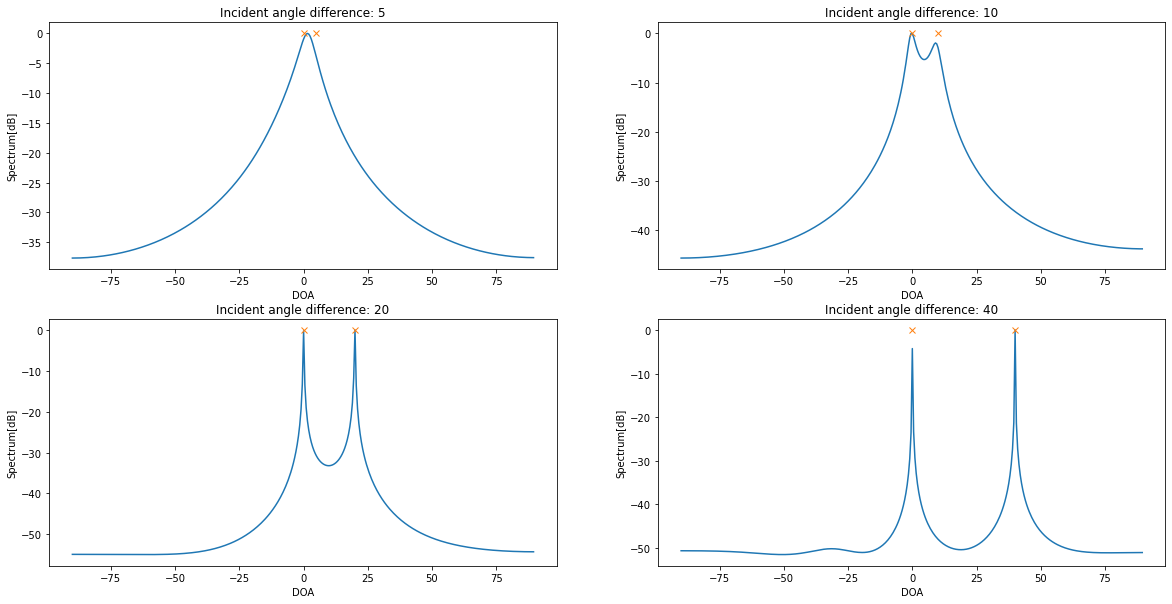

In [7]:
plt.figure(figsize=(20,10))
diff=[5,10,20,40]
f=np.array([1/4, 1/3]) * np.pi 
for i, d in enumerate(diff):
    a=np.array([0,0+d])
    X = generate_data(M,N,d,wavelen,a,f,var)
    Pmusic, peak_search_range= basic_musicDOA(X,M,d,wavelen,thetas)
    plt.subplot(221+i)
    plt.plot(peak_search_range, Pmusic)
    plt.plot(a,np.zeros(a.size),"x")
    plt.title("Incident angle difference: %d"%d)
    plt.xlabel("DOA")
    plt.ylabel("Spectrum[dB]")
plt.show()

### 3.6 DOA estimation for coherent signals

The simulation shows that the classic MUSIC algorithm loses its effectiveness when operating on coherent signals.

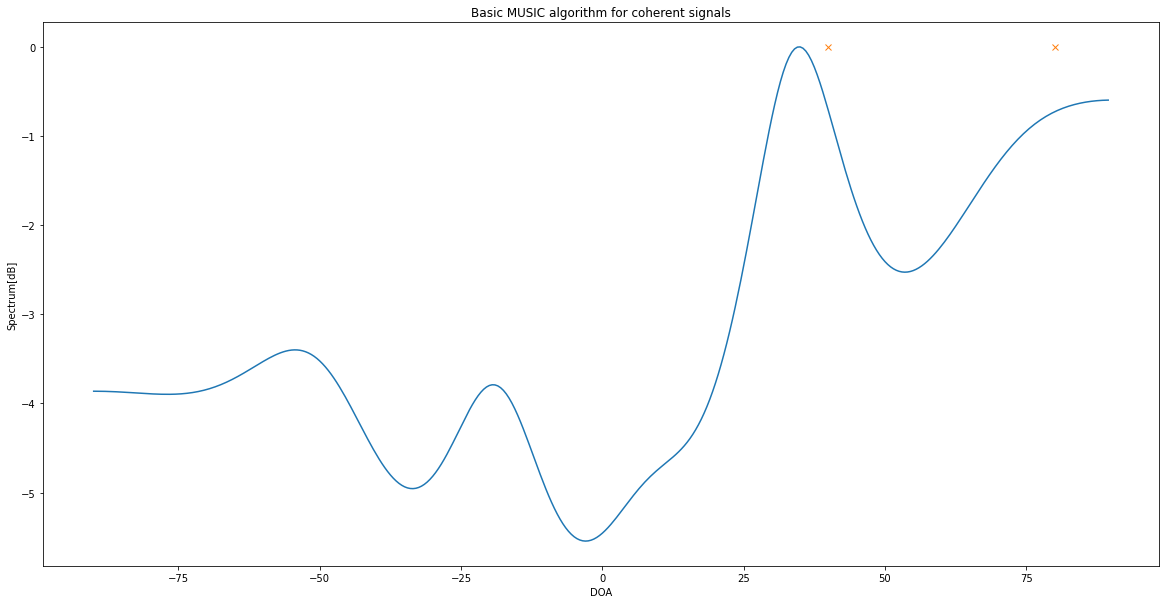

In [8]:
plt.figure(figsize=(20,10))
a=np.array([40, 80])
f=np.array([1/4, 1/4]) * np.pi 
X = generate_data(M,N,d,wavelen,a,f,var)
Pmusic, peak_search_range= basic_musicDOA(X,M,d,wavelen,thetas)
plt.plot(peak_search_range, Pmusic)
plt.plot(a,np.zeros(a.size),"x")
plt.title("Basic MUSIC algorithm for coherent signals")
plt.xlabel("DOA")
plt.ylabel("Spectrum[dB]")
plt.show()